In [4]:
import tensorflow.keras as keras
from ray.tune import track
import numpy as np
np.random.seed(0)

import tensorflow as tf
print(tf.__version__)
try:
    tf.get_logger().setLevel('INFO')
except Exception as exc:
    print(exc)
import warnings
warnings.simplefilter("ignore")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import ray
from ray import tune
import time
import inspect
import pandas as pd
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
%matplotlib inline

'''
class TuneReporterCallback(keras.callbacks.Callback):
    """Tune Callback for Keras.
    
    The callback is invoked every epoch.
    """

    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()

    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        track.log(keras_info=logs, mean_accuracy=logs.get("accuracy"), mean_loss=logs.get("loss"))
    
'''   
class TuneReporterCallback(keras.callbacks.Callback):
    """Tune Callback for Keras.
    
    The callback is invoked every epoch.
    """
    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()
    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        if "acc" in logs:
            tune.report(keras_info=logs, val_loss=logs['val_loss'], mean_accuracy=logs["acc"], f1_m = logs['f1_m'], precision_m=logs['precision_m'], recall_m=logs['recall_m'])
        else:
            tune.report(keras_info=logs, val_loss=logs['val_loss'], mean_accuracy=logs.get("accuracy"), f1_m = logs.get('f1_m'), precision_m=logs.get('precision_m'), recall_m=logs.get('recall_m'))
        time.sleep(0.1)
        
from keras import backend as K
from sklearn.metrics import cohen_kappa_score
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))        
        
def create_model(learning_rate, RNN_units, dropout):
    assert learning_rate > 0 and RNN_units > 0 and dropout > 0, "Did you set the right configuration?"
    input_shape = (32, 32)
    model = Sequential()
    model.add(SimpleRNN(units=int(RNN_units), dropout=dropout, input_shape=input_shape,  activation='relu', name='RNN'))
    model.add(Dense(num_labels, activation = 'softmax', name = 'dense_output'))
    #optimizer = SGD(lr=learning_rate)
    optimizer = Adam(clipvalue=0.5, lr=learning_rate)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
    return model
        
def tune_devnagri(config):  
    model = create_model(learning_rate=config['lr'], RNN_units=int(config['unit']), dropout=config['dropout'])  # TODO: Change me.
    checkpoint_callback = ModelCheckpoint(
        "model.h5", monitor='loss', save_best_only=True, save_freq=2)

    # Enable Tune to make intermediate decisions by using a Tune Callback hook. This is Keras specific.
    callbacks = [checkpoint_callback, TuneReporterCallback()]
    task_dataset = pickle.load(open('/root/Raytune_Devnagri_RNN/task_dataset.pkl', "rb"))
    image_size = 32
    X_train = np.reshape(task_dataset[0],[-1, image_size, image_size]) 
    Y_train = task_dataset[1]
    X_test = np.reshape(task_dataset[2],[-1, image_size, image_size]) 
    Y_test = task_dataset[3]
    # Train the model
    hist = model.fit(
        X_train, Y_train, 
        validation_data=(X_test, Y_test),
        verbose=0, 
        batch_size=100, 
        epochs=10, 
        callbacks=callbacks)
    for key in hist.history:
        print(key)

# Random and uniform sampling for hypertune
def random_search(task_data, task_id=0, cpu_resouce_fed=4):
    import numpy as np; np.random.seed(5)  
    hyperparameter_space = {
        "lr": tune.loguniform(0.001, 0.1),  
        "unit": tune.uniform(50, 80),
        "dropout": tune.loguniform(0.01, 0.3),
    }  
    num_samples = 10 
    ####################################################################################################
    ################ This is just a validation function for tutorial purposes only. ####################
    HP_KEYS = ["lr", "unit", "dropout"]
    assert all(key in hyperparameter_space for key in HP_KEYS), (
        "The hyperparameter space is not fully designated. It must include all of {}".format(HP_KEYS))
    ######################################################################################################

    ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
    ray.init(log_to_driver=False, num_cpus=cpu_resouce_fed)
    # We clean out the logs before running for a clean visualization later.
    ! rm -rf ~/ray_results/tune_devnagri$task_id
    analysis = tune.run(
        tune_devnagri, 
        name="Random_devnagri_task"+str(task_id),
        verbose=1, 
        config=hyperparameter_space,
        num_samples=num_samples)
    time.sleep(1)

    assert len(analysis.trials) > 2, "Did you set the correct number of samples?"

    # Obtain the directory where the best model is saved.
    print("You can use any of the following columns to get the best model: \n{}.".format(
        [k for k in analysis.dataframe() if k.startswith("keras_info")]))
    print("=" * 10)
    logdir = analysis.get_best_logdir("keras_info/val_acc", mode="max")
    print('Best model:',analysis.get_best_trial(metric='keras_info/val_acc', mode='max'), 
          'lr:', analysis.get_best_config(metric='keras_info/val_acc', mode='max')['lr'], 'unit:', analysis.get_best_config(metric='keras_info/val_acc', mode='max')['unit'], 'dropout:', analysis.get_best_config(metric='keras_info/val_acc', mode='max')['dropout'] )
    # We saved the model as `model.h5` in the logdir of the trial.
    from tensorflow.keras.models import load_model
    tuned_model = load_model(logdir + "/model.h5", custom_objects =  {'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m})
    tuned_model.summary()
    image_size = 32
    X_test = np.reshape(task_data[2],[-1, image_size, image_size])  
    Y_test = task_data[3]
    tuned_loss, tuned_accuracy, f1_score, precision, recall = tuned_model.evaluate(X_test, Y_test, verbose=0)
    print("Loss is {:0.4f}".format(tuned_loss))
    print("Tuned accuracy is {:0.4f}".format(tuned_accuracy))
    print ('F1-score = {0}'.format(f1_score))
    print ('Precision = {0}'.format(precision))
    print ('Recall = {0}'.format(recall))
    return(analysis.get_best_config(metric='keras_info/acc', mode='max'))

#PBT population based sampling 
def mutation_pbtsearch(task_data, task_id=0, cpu_resouce_fed=4):
    from ray.tune.schedulers import PopulationBasedTraining
    from ray.tune.utils import validate_save_restore
    scheduler = PopulationBasedTraining(
        time_attr="training_iteration",
        metric="mean_accuracy",
        mode="max",
        perturbation_interval=20,
        hyperparam_mutations={
            # distribution for resampling
            "lr": lambda: np.random.uniform(0.0001, 1),
            # allow perturbations within this set of categorical values
            "unit": [60, 80, 100], "dropout": [0.1, 0.2, 0.3], 
        }
    )

    old_dirs = os.listdir('/root/ray_results/')

    ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
    ray.init(log_to_driver=False, num_cpus=cpu_resouce_fed)
    ! rm -rf ~/ray_results/PBT_devnagri_task$task_id
    analysis = tune.run(
        tune_devnagri,
        name="PBT_devnagri_task"+str(task_id),
        scheduler=scheduler,
        reuse_actors=True,
        verbose=1,
        stop={
            "training_iteration": 100,
        },
        num_samples=10,

        # PBT starts by training many neural networks in parallel with random hyperparameters. 
        config={
        "lr": tune.loguniform(0.001, 0.1),  
        "unit": tune.uniform(50, 80),
        "dropout": tune.loguniform(0.01, 0.3),
    } )
    time.sleep(1)
    print("You can use any of the following columns to get the best model: \n{}.".format(
        [k for k in analysis.dataframe() if k.startswith("keras_info")]))
    print("=" * 10)
    logdir = analysis.get_best_logdir("keras_info/val_acc", mode="max")
    print('Best model:',analysis.get_best_trial(metric='keras_info/val_acc', mode='max'), 
          analysis.get_best_config(metric='keras_info/val_acc', mode='max'))
    # We saved the model as `model.h5` in the logdir of the trial.
    from tensorflow.keras.models import load_model
    tuned_model = load_model(logdir + "/model.h5", custom_objects =  {'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m})
    tuned_model.summary()
    image_size = 32
    X_test = np.reshape(task_data[2],[-1, image_size, image_size])
    Y_test = task_data[3]
    tuned_loss, tuned_accuracy, f1_score, precision, recall = tuned_model.evaluate(X_test, Y_test, verbose=0)
    print("Loss is {:0.4f}".format(tuned_loss))
    print("Tuned accuracy is {:0.4f}".format(tuned_accuracy))
    print ('F1-score = {0}'.format(f1_score))
    print ('Precision = {0}'.format(precision))
    print ('Recall = {0}'.format(recall))
    return(analysis.get_best_config(metric='keras_info/acc', mode='max'))

#ASHA Schedular
def ASHA_search(task_data, task_id=0, cpu_resouce_fed=4):
    from ray.tune.schedulers import ASHAScheduler
    ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
    ray.init(log_to_driver=False, num_cpus=cpu_resouce_fed)
    custom_scheduler = ASHAScheduler(
        metric='mean_accuracy',
        mode="max",
        reduction_factor = 4,
        grace_period=1)# TODO: Add a ASHA as custom scheduler here
    hyperparameter_space={
        "lr": tune.loguniform(0.001, 0.1),  
        "unit": tune.uniform(50, 80),
        "dropout": tune.loguniform(0.01, 0.3),
    } 
    ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
    ray.init(log_to_driver=False, num_cpus=cpu_resouce_fed)
    ! rm -rf ~/ray_results/ASHA_devnagri_task$task_id
    analysis = tune.run(
        tune_devnagri, 
        scheduler=custom_scheduler, 
        config=hyperparameter_space, 
        verbose=1,
        num_samples=10,
        #resources_per_trial={"cpu":4},
        name="ASHA_devnagri_task"+str(task_id)  # This is used to specify the logging directory.
    )
    time.sleep(1)
    print("You can use any of the following columns to get the best model: \n{}.".format(
        [k for k in analysis.dataframe() if k.startswith("keras_info")]))
    print("=" * 10)
    logdir = analysis.get_best_logdir("keras_info/acc", mode="max")
    print('Best model:',analysis.get_best_trial(metric='keras_info/acc', mode='max'), 
          analysis.get_best_config(metric='keras_info/acc', mode='max'))
    # We saved the model as `model.h5` in the logdir of the trial.
    from tensorflow.keras.models import load_model
    tuned_model = load_model(logdir + "/model.h5", custom_objects =  {'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m})
    tuned_model.summary()
    image_size = 32
    X_test = np.reshape(task_data[2],[-1, image_size, image_size])
    Y_test = task_data[3]
    tuned_loss, tuned_accuracy, f1_score, precision, recall = tuned_model.evaluate(X_test, Y_test, verbose=0)
    print("Loss is {:0.4f}".format(tuned_loss))
    print("Tuned accuracy is {:0.4f}".format(tuned_accuracy))
    print ('F1-score = {0}'.format(f1_score))
    print ('Precision = {0}'.format(precision))
    print ('Recall = {0}'.format(recall))
    return(analysis.get_best_config(metric='keras_info/acc', mode='max'))


#HyperOpt Search 
def hyperopt_search(task_data, task_id=0, cpu_resouce_fed=4):
    from ray.tune.suggest import ConcurrencyLimiter
    from ray.tune.schedulers import AsyncHyperBandScheduler
    from ray.tune.suggest.hyperopt import HyperOptSearch

    
    search_space={
        "lr": tune.loguniform(0.001, 0.1),  
        "unit": tune.uniform(50, 80),
        "dropout": tune.loguniform(0.01, 0.3),
    }
    current_best_params = [{
    'lr': 0.01,
    'unit': 25,
    'dropout': 0.2,
    }]
    scheduler = AsyncHyperBandScheduler()
    
    algo = HyperOptSearch(points_to_evaluate=current_best_params)
    algo = ConcurrencyLimiter(algo, max_concurrent=cpu_resouce_fed)
    ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
    ray.init(log_to_driver=False, num_cpus=cpu_resouce_fed)
    ! rm -rf ~/ray_results/BayesOptSearch_devnagri_task$task_id
    analysis =tune.run(tune_Drebin,
        name="hyperopt_devnagri_task"+str(task_id), verbose = 1,
        scheduler=scheduler,
        search_alg=algo,
        num_samples=10, 
        metric="mean_accuracy",
        mode="max",
        config=search_space,
        stop={"training_iteration": 150})
    time.sleep(1)
    #from ray.tune import Analysis as analysis
    #analysis = ray.tune.Analysis('/root/ray_results/BayesOptSearch_ASNM') 
    print("You can use any of the following columns to get the best model: \n{}.".format(
        [k for k in analysis.dataframe() if k.startswith("keras_info")]))
    print("=" * 10)
    logdir = analysis.get_best_logdir("keras_info/acc", mode="max")
    print('Best model:', analysis.get_best_config(metric='keras_info/acc', mode='max'))
    # We saved the model as `model.h5` in the logdir of the trial.
    from tensorflow.keras.models import load_model
    tuned_model = load_model(logdir + "/model.h5", custom_objects =  {'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m})
    tuned_model.summary()
    image_size = 32
    X_test = np.reshape(task_data[2],[-1, image_size, image_size])
    Y_test = task_data[3]
    tuned_loss, tuned_accuracy, f1_score, precision, recall = tuned_model.evaluate(X_test, Y_test, verbose=0)
    print("Loss is {:0.4f}".format(tuned_loss))
    print("Tuned accuracy is {:0.4f}".format(tuned_accuracy))
    print ('F1-score = {0}'.format(f1_score))
    print ('Precision = {0}'.format(precision))
    print ('Recall = {0}'.format(recall))
    return(analysis.get_best_config(metric='keras_info/acc', mode='max'))

def BayesOptSearch(task_data, task_id=0, cpu_resouce_fed=4):
    from ray.tune.schedulers import AsyncHyperBandScheduler
    from ray.tune.suggest import ConcurrencyLimiter
    from ray.tune.suggest.bayesopt import BayesOptSearch
    
    search_space={
        "lr": tune.loguniform(0.001, 0.1),  
        "unit": tune.uniform(50, 80),
        "dropout": tune.loguniform(0.01, 0.3),
    } 
    scheduler = AsyncHyperBandScheduler()
    
    algo = ConcurrencyLimiter(BayesOptSearch(utility_kwargs={
        "kind": "ucb",
        "kappa": 2.5,
        "xi": 0.0
        }, metric = 'mean_accuracy', mode = 'max'), 
        max_concurrent=cpu_resouce_fed)
    ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
    ray.init(log_to_driver=False, num_cpus=cpu_resouce_fed)
    ! rm -rf ~/ray_results/BayesOptSearch_devnagri_task$task_id
    analysis =tune.run(tune_devnagri,
        name="BayesOptSearch_devnagri_task"+str(task_id), verbose = 1,
        scheduler=scheduler,
        search_alg=algo,
        num_samples=100, 
        metric="mean_accuracy",
        mode="max",
        config=search_space,
        stop={"training_iteration": 150})
    time.sleep(1)
    #from ray.tune import Analysis as analysis
    #analysis = ray.tune.Analysis('/root/ray_results/BayesOptSearch_ASNM') 
    print("You can use any of the following columns to get the best model: \n{}.".format(
        [k for k in analysis.dataframe() if k.startswith("keras_info")]))
    print("=" * 10)
    logdir = analysis.get_best_logdir("keras_info/acc", mode="max")
    print('Best model:', analysis.get_best_config(metric='keras_info/acc', mode='max'))
    # We saved the model as `model.h5` in the logdir of the trial.
    from tensorflow.keras.models import load_model
    tuned_model = load_model(logdir + "/model.h5", custom_objects =  {'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m})
    tuned_model.summary()
    image_size = 32
    X_test = np.reshape(task_data[2],[-1, image_size, image_size])
    Y_test = task_data[3]
    tuned_loss, tuned_accuracy, f1_score, precision, recall = tuned_model.evaluate(X_test, Y_test, verbose=0)
    print("Loss is {:0.4f}".format(tuned_loss))
    print("Tuned accuracy is {:0.4f}".format(tuned_accuracy))
    print ('F1-score = {0}'.format(f1_score))
    print ('Precision = {0}'.format(precision))
    print ('Recall = {0}'.format(recall))
    return(analysis.get_best_config(metric='keras_info/acc', mode='max'))


def NeverGradSearch(task_data, task_id=0, cpu_resouce_fed=4):
    from ray.tune.suggest import ConcurrencyLimiter
    from ray.tune.schedulers import AsyncHyperBandScheduler
    from ray.tune.suggest.nevergrad import NevergradSearch
    import nevergrad as ng
    
    search_space={
        "lr": tune.loguniform(0.001, 0.1),  
        "unit": tune.uniform(50, 80),
        "dropout": tune.loguniform(0.01, 0.3),
    } 
    scheduler = AsyncHyperBandScheduler()
    
    algo = NevergradSearch(
        optimizer=ng.optimizers.OnePlusOne,
        # space=space,  # If you want to set the space manually
    )
    algo = ConcurrencyLimiter(algo, max_concurrent=cpu_resouce_fed)
    ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
    ray.init(log_to_driver=False, num_cpus=cpu_resouce_fed)
    ! rm -rf ~/ray_results/BayesOptSearch_devnagri_task$task_id
    analysis =tune.run(tune_devnagri,
        name="NeverGradSearch_devnagri_task"+str(task_id), verbose = 1,
        scheduler=scheduler,
        search_alg=algo,
        num_samples=10, 
        metric="mean_accuracy",
        mode="max",
        config=search_space,
        stop={"training_iteration": 150})
    time.sleep(1)
    #from ray.tune import Analysis as analysis
    #analysis = ray.tune.Analysis('/root/ray_results/BayesOptSearch_ASNM') 
    print("You can use any of the following columns to get the best model: \n{}.".format(
        [k for k in analysis.dataframe() if k.startswith("keras_info")]))
    print("=" * 10)
    logdir = analysis.get_best_logdir("keras_info/acc", mode="max")
    print('Best model:', analysis.get_best_config(metric='keras_info/acc', mode='max'))
    # We saved the model as `model.h5` in the logdir of the trial.
    from tensorflow.keras.models import load_model
    tuned_model = load_model(logdir + "/model.h5", custom_objects =  {'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m})
    tuned_model.summary()
    image_size = 32
    X_test = np.reshape(task_data[2],[-1, image_size, image_size])
    Y_test = task_data[3]
    tuned_loss, tuned_accuracy, f1_score, precision, recall = tuned_model.evaluate(X_test, Y_test, verbose=0)
    print("Loss is {:0.4f}".format(tuned_loss))
    print("Tuned accuracy is {:0.4f}".format(tuned_accuracy))
    print ('F1-score = {0}'.format(f1_score))
    print ('Precision = {0}'.format(precision))
    print ('Recall = {0}'.format(recall))
    return(analysis.get_best_config(metric='keras_info/acc', mode='max'))

def OptunaSearch(task_data, task_id=0, cpu_resouce_fed=4):
    from ray.tune.suggest import ConcurrencyLimiter
    from ray.tune.schedulers import AsyncHyperBandScheduler
    from ray.tune.suggest.optuna import OptunaSearch
    
    search_space={
        "lr": tune.loguniform(0.001, 0.1),  
        "unit": tune.uniform(50, 80),
        "dropout": tune.loguniform(0.01, 0.3),
    } 
    scheduler = AsyncHyperBandScheduler()
    
    algo = OptunaSearch(metric="mean_accuracy",
        mode="max")
    algo = ConcurrencyLimiter(algo, max_concurrent=cpu_resouce_fed)
    ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
    ray.init(log_to_driver=False, num_cpus=cpu_resouce_fed)
    ! rm -rf ~/ray_results/BayesOptSearch_devnagri_task$task_id
    analysis =tune.run(tune_devnagri,
        name="OptunaSearch_devnagri_task"+str(task_id), verbose = 1,
        scheduler=scheduler,
        search_alg=algo,
        num_samples=10, 
        metric="mean_accuracy",
        mode="max",
        config=search_space,
        stop={"training_iteration": 150})
    time.sleep(1)
    #from ray.tune import Analysis as analysis
    #analysis = ray.tune.Analysis('/root/ray_results/BayesOptSearch_ASNM') 
    print("You can use any of the following columns to get the best model: \n{}.".format(
        [k for k in analysis.dataframe() if k.startswith("keras_info")]))
    print("=" * 10)
    logdir = analysis.get_best_logdir("keras_info/acc", mode="max")
    print('Best model:', analysis.get_best_config(metric='keras_info/acc', mode='max'))
    # We saved the model as `model.h5` in the logdir of the trial.
    from tensorflow.keras.models import load_model
    tuned_model = load_model(logdir + "/model.h5", custom_objects =  {'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m})
    tuned_model.summary()
    image_size = 32
    X_test = np.reshape(task_data[2],[-1, image_size, image_size])
    Y_test = task_data[3]
    tuned_loss, tuned_accuracy, f1_score, precision, recall = tuned_model.evaluate(X_test, Y_test, verbose=0)
    print("Loss is {:0.4f}".format(tuned_loss))
    print("Tuned accuracy is {:0.4f}".format(tuned_accuracy))
    print ('F1-score = {0}'.format(f1_score))
    print ('Precision = {0}'.format(precision))
    print ('Recall = {0}'.format(recall))
    return(analysis.get_best_config(metric='keras_info/acc', mode='max'))

def ZOOptSearch(task_data, task_id=0, cpu_resouce_fed=4):
    from ray.tune.suggest.zoopt import ZOOptSearch
    from ray.tune.schedulers import AsyncHyperBandScheduler
    from zoopt import ValueType  # noqa: F401
    
    search_space={
        "lr": tune.loguniform(0.001, 0.1),  
        "unit": tune.uniform(50, 80),
        "dropout": tune.loguniform(0.01, 0.3),
    }
    scheduler = AsyncHyperBandScheduler()
    num_samples = 10
    zoopt_search_config = {
        "parallel_num": cpu_resouce_fed,
    }

    algo = ZOOptSearch(
        algo="Asracos",  # only support ASRacos currently
        budget=num_samples,
        # dim_dict=space,  # If you want to set the space yourself
        **zoopt_search_config)
    ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
    ray.init(log_to_driver=False, num_cpus=cpu_resouce_fed)
    ! rm -rf ~/ray_results/BayesOptSearch_devnagri_task$task_id
    analysis =tune.run(tune_devnagri,
        name="ZOOptSearch_devnagri_task"+str(task_id), verbose = 1,
        scheduler=scheduler,
        search_alg=algo,
        num_samples=num_samples, 
        metric="mean_accuracy",
        mode="max",
        config=search_space,
        stop={"training_iteration": 150})
    time.sleep(1)
    #from ray.tune import Analysis as analysis
    #analysis = ray.tune.Analysis('/root/ray_results/BayesOptSearch_ASNM') 
    print("You can use any of the following columns to get the best model: \n{}.".format(
        [k for k in analysis.dataframe() if k.startswith("keras_info")]))
    print("=" * 10)
    logdir = analysis.get_best_logdir("keras_info/acc", mode="max")
    print('Best model:', analysis.get_best_config(metric='keras_info/acc', mode='max'))
    # We saved the model as `model.h5` in the logdir of the trial.
    from tensorflow.keras.models import load_model
    tuned_model = load_model(logdir + "/model.h5", custom_objects =  {'f1_m': f1_m, 'precision_m': precision_m, 'recall_m': recall_m})
    tuned_model.summary()
    image_size = 32
    X_test = np.reshape(task_data[2],[-1, image_size, image_size])
    Y_test = task_data[3]
    tuned_loss, tuned_accuracy, f1_score, precision, recall = tuned_model.evaluate(X_test, Y_test, verbose=0)
    print("Loss is {:0.4f}".format(tuned_loss))
    print("Tuned accuracy is {:0.4f}".format(tuned_accuracy))
    print ('F1-score = {0}'.format(f1_score))
    print ('Precision = {0}'.format(precision))
    print ('Recall = {0}'.format(recall))
    return(analysis.get_best_config(metric='keras_info/acc', mode='max'))

1.14.0


In [5]:
import pickle
import pdb
import time
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        last_model_stats = Model_Perf_save
        for i,lay in enumerate(model.layers):
            last_model_size = last_model_stats['shape'][-1][2*i+1][0]
            layer_weights = lay.get_weights()
            layer_weights[0][:last_model_stats['weights'][-1][3*i].shape[0],:last_model_size] = last_model_stats['weights'][-1][3*i]
            if i != len(model.layers)-1: #for last (dense) layer
                layer_weights[1][:last_model_stats['weights'][-1][3*i+1].shape[0],:last_model_size] = last_model_stats['weights'][-1][3*i+1]
                layer_weights[2][:last_model_size] = last_model_stats['weights'][-1][3*i+2]
            else:
                layer_weights[1][:last_model_size] = last_model_stats['weights'][-1][3*i+1]
            model.layers[i].set_weights(layer_weights)      

    def on_batch_end(self, batch, logs={}):
        last_model_stats = Model_Perf_save
        for i,lay in enumerate(model.layers):
            last_model_size = last_model_stats['shape'][-1][2*i+1][0]
            layer_weights = lay.get_weights()
            layer_weights[0][:last_model_stats['weights'][-1][3*i].shape[0],:last_model_size] = last_model_stats['weights'][-1][3*i]
            if i != len(model.layers)-1: #for last (dense) layer
                layer_weights[1][:last_model_stats['weights'][-1][3*i+1].shape[0],:last_model_size] = last_model_stats['weights'][-1][3*i+1]
                layer_weights[2][:last_model_size] = last_model_stats['weights'][-1][3*i+2]
            else:
                layer_weights[1][:last_model_size] = last_model_stats['weights'][-1][3*i+1]
            model.layers[i].set_weights(layer_weights)  
        
def create_task(data_path):
    data = pickle.load(open(data_path, "rb"))
    return data

def measure_CPU_Mem():
    import psutil
    CPU_usage_dump = []
    Mem_usage_dump = []  
    while True:
        CPU_usage_dump.append(psutil.cpu_percent())
        Mem_usage_dump.append(psutil.virtual_memory().percent)
        f_cpu=open("CPU_used.txt", "wb")
        f_mem=open("Mem_used.txt", "wb")
        pickle.dump(CPU_usage_dump, f_cpu) 
        pickle.dump(Mem_usage_dump, f_mem)     
        f_cpu.close()
        f_mem.close()
        time.sleep(1)

import multiprocessing
task_list = create_task('devnagri_tasks.pkl')
num_tasks=11
num_labels=46
Model_Perf_save = {}
Model_Perf_save['tr_acc'] = []
Model_Perf_save['val_acc'] = []
Model_Perf_save['precision'] = []
Model_Perf_save['recall'] = []
Model_Perf_save['f1_score'] = []
Model_Perf_save['shape'] = []
Model_Perf_save['weights'] = []
Model_Perf_save['learn_rate'] = []
Model_Perf_save['dropout'] = []
cpu_resouce_fed = 3
for search_algo in [ 
                    random_search,
                    #ASHA_search,
                    #mutation_pbtsearch,
                    #BayesOptSearch,
                    #NeverGradSearch,
                    #OptunaSearch,
                    #ZOOptSearch,
                    #hyperopt_search
                    ]:
    cpu_mem_collection = multiprocessing.Process(target=measure_CPU_Mem)
    cpu_mem_collection.start()
    start_time = time.time()
    for task_id in range(0,num_tasks):
        !rm -rf task_dataset.pkl
        f = open('task_dataset.pkl', 'wb')
        pickle.dump(task_list[task_id], f)
        f.close()
        hyper_param = search_algo(task_list[task_id], task_id, cpu_resouce_fed)
        image_size = 32
        if task_id == 0:
            model = create_model(learning_rate=hyper_param['lr'], RNN_units=int(hyper_param['unit']), dropout=hyper_param['dropout'])
            #call one of the search algorithm
            history = model.fit(np.reshape(task_list[task_id][0],[-1, image_size, image_size]), 
                  task_list[task_id][1], batch_size=128, epochs=10, verbose=1,
                  validation_data=(np.reshape(task_list[task_id][2],[-1, image_size, image_size]), task_list[task_id][3]))
        else:
            rnn_units = hyper_param["unit"] + Model_Perf_save['shape'][-1][1][0]
            model = create_model(learning_rate=hyper_param['lr'], RNN_units=int(rnn_units), dropout=hyper_param['dropout'])
            history = model.fit(np.reshape(task_list[task_id][0],[-1, image_size, image_size]),
                  task_list[task_id][1], batch_size=128, epochs=10, verbose=1,
                  validation_data=(np.reshape(task_list[task_id][2],[-1, image_size, image_size]), task_list[task_id][3]), callbacks  = [LossHistory()])
        loss_and_metrics = model.evaluate(np.reshape(task_list[task_id][0],[-1, image_size, image_size]), task_list[task_id][1], verbose=0)
        Model_Perf_save['tr_acc'].append(loss_and_metrics[1])
        loss_and_metrics = model.evaluate(np.reshape(task_list[task_id][4],[-1, image_size, image_size]), task_list[task_id][5], verbose=0)
        Model_Perf_save['val_acc'].append(loss_and_metrics[1])
        Model_Perf_save['f1_score'].append(loss_and_metrics[2])
        Model_Perf_save['precision'].append(loss_and_metrics[3])
        Model_Perf_save['recall'].append(loss_and_metrics[4])
        Model_Perf_save['shape'].append([i.shape for i in model.get_weights()])
        Model_Perf_save['learn_rate'].append(hyper_param["lr"])
        Model_Perf_save['dropout'].append(hyper_param["dropout"])
        Model_Perf_save['weights'].append(model.get_weights()) 
    end_time = time.time()
    print('Search algorithm {} took {}.'.format(search_algo.__name__, end_time - start_time))
    
    f=open("time_taken.txt", "a+")
    f.write('Time taken for algo {} is {}. \n'.format(search_algo.__name__, end_time-start_time))

    try:
        f_cpu=open("CPU_used.txt", "rb")
        f_mem=open("Mem_used.txt", "rb")
        cpu_usage = pickle.load(f_cpu)
        mem_usage = pickle.load(f_mem)
        f_cpu.close()
        f_mem.close()
        cpu_mem_collection.terminate()
        cpu_mem_collection.join()
        f.write('CPU used is {}. \n'.format(np.mean(cpu_usage)))
        f.write('Memory used is {}. \n \n'.format(np.mean(mem_usage)))
        f.close()
    except:
        pass

Trial name,status,loc,dropout,lr,unit,acc,iter,total time (s),val_loss,f1_m,precision_m
tune_devnagri_091d1_00000,TERMINATED,,0.0201999,0.00277963,76.122,0.97923,10,6.9105,0.0830729,0.97868,0.979596
tune_devnagri_091d1_00001,TERMINATED,,0.0800977,0.0687419,64.6523,0.513973,10,5.64536,4.40282e+15,0.514506,0.514506
tune_devnagri_091d1_00002,TERMINATED,,0.0274417,0.0340264,65.5525,0.900302,10,5.88597,0.243543,0.898979,0.900006
tune_devnagri_091d1_00003,TERMINATED,,0.123244,0.00237379,52.4222,0.879154,10,5.9245,0.2302,0.878813,0.881887
tune_devnagri_091d1_00004,TERMINATED,,0.199422,0.00763165,54.7493,0.917674,10,5.82543,0.179132,0.914193,0.919403
tune_devnagri_091d1_00005,TERMINATED,,0.0273745,0.00353324,62.4271,0.982251,10,6.12617,0.0348237,0.982767,0.983318
tune_devnagri_091d1_00006,TERMINATED,,0.0769428,0.0180957,67.3951,0.859517,10,6.17661,0.276234,0.854094,0.86864
tune_devnagri_091d1_00007,TERMINATED,,0.0236908,0.00340125,58.5406,0.960347,10,5.99072,0.247694,0.960112,0.961009
tune_devnagri_091d1_00008,TERMINATED,,0.0175643,0.00451989,54.3249,0.973943,10,5.80867,0.0849027,0.973992,0.976543
tune_devnagri_091d1_00009,TERMINATED,,0.0189807,0.0846956,78.8068,0.486027,10,5.78423,2.13439e+16,0.485895,0.485895


2023-06-22 09:56:56,112	INFO tune.py:439 -- Total run time: 36.97 seconds (36.85 seconds for the tuning loop).


You can use any of the following columns to get the best model: 
['keras_info/loss', 'keras_info/acc', 'keras_info/f1_m', 'keras_info/precision_m', 'keras_info/recall_m', 'keras_info/val_loss', 'keras_info/val_acc', 'keras_info/val_f1_m', 'keras_info/val_precision_m', 'keras_info/val_recall_m'].
Best model: tune_devnagri_091d1_00005 lr: 0.0035332382550846446 unit: 62.42705057243154 dropout: 0.027374485268163815
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
RNN (SimpleRNN)              (None, 62)                5890      
_________________________________________________________________
dense_output (Dense)         (None, 46)                2898      
Total params: 8,788
Trainable params: 8,788
Non-trainable params: 0
_________________________________________________________________
Loss is 0.0791
Tuned accuracy is 0.9726
F1-score = 0.9731104373931885
Precision = 0.9731104373931885


In [6]:
for j,search_algo in enumerate([
                    #ASHA_search, 
                    random_search,
                    #mutation_pbtsearch,
                    #BayesOptSearch,
                    #NeverGradSearch,
                    #OptunaSearch,
                    #ZOOptSearch,
                    #hyperopt_search
                    ]):
    print('Search Algorithm: {0}'.format(search_algo.__name__))
    print('Training accuracy for tasks:',Model_Perf_save['tr_acc'][j*num_tasks:j*num_tasks+num_tasks])
    print('Validation accuracy for tasks:',Model_Perf_save['val_acc'][j*num_tasks:j*num_tasks+num_tasks])
    print('Precision:',Model_Perf_save['precision'][j*num_tasks:j*num_tasks+num_tasks])
    print('Recall:',Model_Perf_save['recall'][j*num_tasks:j*num_tasks+num_tasks])
    print('F1 score:',Model_Perf_save['f1_score'][j*num_tasks:j*num_tasks+num_tasks])
    print('Nodes in hidden layer: ',[(i[0])for i in Model_Perf_save['shape']][j*num_tasks:j*num_tasks+num_tasks])
    print('Learning rates: ', Model_Perf_save['learn_rate'][j*num_tasks:j*num_tasks+num_tasks])
    print('Dropout probability: ', Model_Perf_save['dropout'][j*num_tasks:j*num_tasks+num_tasks])
    print('------------------------')

Search Algorithm: random_search
Training accuracy for tasks: [0.9817164, 0.9617225, 0.98948556, 0.97164947, 0.97676134, 0.9828869, 0.9907613, 0.9829503, 0.84730196, 0.99317926, 0.94070995]
Validation accuracy for tasks: [0.9765152, 0.95011693, 0.9842932, 0.9727414, 0.97439873, 0.98018295, 0.9853169, 0.9831029, 0.8377794, 0.98677444, 0.9341716]
Precision: [0.97693455, 0.9512195, 0.9841666, 0.97548676, 0.97484756, 0.9809451, 0.9855183, 0.98288524, 0.8450279, 0.9869186, 0.9353198]
Recall: [0.97693455, 0.9512195, 0.9841666, 0.9702744, 0.97484756, 0.9794207, 0.9855183, 0.98288524, 0.8267691, 0.9869186, 0.9353198]
F1 score: [0.97693455, 0.9512195, 0.9841666, 0.9728392, 0.97484756, 0.98017085, 0.9855183, 0.98288524, 0.8355972, 0.9869186, 0.9353198]
Nodes in hidden layer:  [(32, 58), (32, 134), (32, 210), (32, 264), (32, 340), (32, 402), (32, 456), (32, 510), (32, 568), (32, 644), (32, 706)]
Learning rates:  [0.0034012474960852393, 0.002779625851893939, 0.002779625851893939, 0.0045198903102267

#### Inspecting the weights/bias matrix size after learning each task.

In [7]:
for i,task in enumerate(Model_Perf_save['weights']):
    print(f'For task {i+1}.------ {[layer.shape for layer in task]}')

For task 1.------ [(32, 58), (58, 58), (58,), (58, 46), (46,)]
For task 2.------ [(32, 134), (134, 134), (134,), (134, 46), (46,)]
For task 3.------ [(32, 210), (210, 210), (210,), (210, 46), (46,)]
For task 4.------ [(32, 264), (264, 264), (264,), (264, 46), (46,)]
For task 5.------ [(32, 340), (340, 340), (340,), (340, 46), (46,)]
For task 6.------ [(32, 402), (402, 402), (402,), (402, 46), (46,)]
For task 7.------ [(32, 456), (456, 456), (456,), (456, 46), (46,)]
For task 8.------ [(32, 510), (510, 510), (510,), (510, 46), (46,)]
For task 9.------ [(32, 568), (568, 568), (568,), (568, 46), (46,)]
For task 10.------ [(32, 644), (644, 644), (644,), (644, 46), (46,)]
For task 11.------ [(32, 706), (706, 706), (706,), (706, 46), (46,)]


#### Analyzing the weights/bias to verify that current weights are frozen while learning future tasks.

In [8]:
for i in range(len(Model_Perf_save['weights'])):
    print(f'--------------Comparing with {i+1}th task.----------------')
    for j in range((i+1), len(Model_Perf_save['weights'])):
        print(f'For {j}th weight array.')
        for weightarray_num in range(4):   #Looping over all the weight arry except last 
            try:
                print(Model_Perf_save['weights'][i][weightarray_num] == Model_Perf_save['weights'][i][weightarray_num][:Model_Perf_save['weights'][i][:weightarray_num].shape[0],:Model_Perf_save['weights'][i][weightarray_num].shape[1]])
            except:
                print(Model_Perf_save['weights'][i][weightarray_num] == Model_Perf_save['weights'][i][weightarray_num][:len(Model_Perf_save['weights'][i][weightarray_num])])
                

--------------Comparing with 1th task.----------------
For 1th weight array.
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True]
[[ True  True  True ...  True  True  True

#### Plotting weights centroid

Total number of parameters for task 1 is 7992.
Total number of parameters for task 2 is 28588.
Total number of parameters for task 3 is 60736.
Total number of parameters for task 4 is 90598.
Total number of parameters for task 5 is 142506.
Total number of parameters for task 6 is 193408.
Total number of parameters for task 7 is 244006.
Total number of parameters for task 8 is 300436.
Total number of parameters for task 9 is 367542.
Total number of parameters for task 10 is 465658.


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


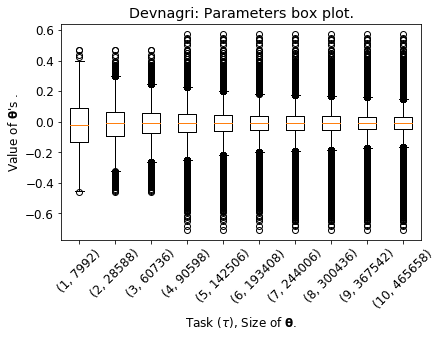

In [9]:
import itertools
import pdb
import collections

def flatten(weights):
    w = []
    for l in weights:
        if isinstance(l, collections.Iterable):
            w = w + flatten(l)
        else:
            w = w + [l]
    return w

all_weights = {}
boxplot_data = []
for i,task in enumerate(Model_Perf_save['weights'][:10]):
    all_weights[i+1] = flatten(task)
    boxplot_data.append(all_weights[i+1])
    print(f'Total number of parameters for task {i+1} is {len(all_weights[i+1])}.')
import matplotlib
font = {'family' : 'normal',
        'weight'  : 'normal',
        'size'   : 12}
matplotlib.rc('font', **font)
import matplotlib.pyplot as plt
fig = plt.figure(figsize =(5, 3))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(boxplot_data) 
ax.set_xlabel(r'Task ($\tau$), Size of $\mathbf{\theta}$.')
plt.title('Devnagri: Parameters box plot.')
ax.set_ylabel(r"Value of $\mathbf{\theta}$'s .")
ax.set_xticklabels([(i+1,len(all_weights[i+1])) for i in range(len(all_weights.keys()))], rotation = 45)
plt.savefig('Devnagri_params_boxplot.pdf', bbox_inches='tight')
plt.show()